# Exploratory Data analysis
- Time Series Analysis
- Time Series Components
- Time Series Decomposition

In [328]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf
#Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.signal import periodogram
from eval import loadPrices

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

Text(0, 0.5, 'stock price')

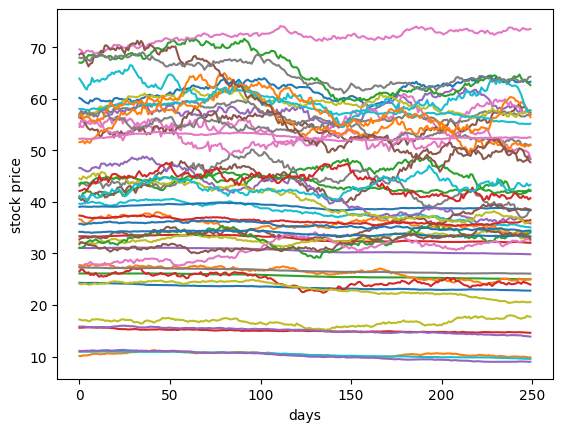

In [23]:
# Load 250 days of data
pricesFile="./prices.txt"
prcAll_np = loadPrices(pricesFile)

for stock in prcAll_np:
    plt.plot(stock)
plt.xlabel('days')
plt.ylabel('stock price')

# Time Series Components
A useful abstraction for selecting forecasting methods is to break a time series down into systematic and unsystematic components.

Systematic: Components of the time series that have consistency or recurrence and can be described and modeled.

Non-Systematic: Components of the time series that cannot be directly modeled.

- Level: The baseline value for the series if it were a straight line.
- Trend: The optional and often linear increasing or decreasing behavior of the series over time.
- Seasonality: The optional repeating patterns or cycles of behavior over time.
- residual(Noise): The random variation in the series.

## Additive Model
- y(t) = Level + Trend + Seasonality + Noise
- An additive model is linear where changes over time are consistently made by the same amount.
- A linear trend is a straight line.
- A linear seasonality has the same frequency (width of cycles) and amplitude (height of cycles).

## Multiplicative Model
- y(t) = Level * Trend * Seasonality * Noise
- A multiplicative model is nonlinear, such as quadratic or exponential. Changes increase or decrease over time.
- A nonlinear trend is a curved line.
- A non-linear seasonality has an increasing or decreasing frequency and/or amplitude over time.




# Time Series Decomposition (classical method)
- Trend, Seasonality, residuals
- Decomposition helps to identify underlying patterns and understand the different sources of variation in the data.

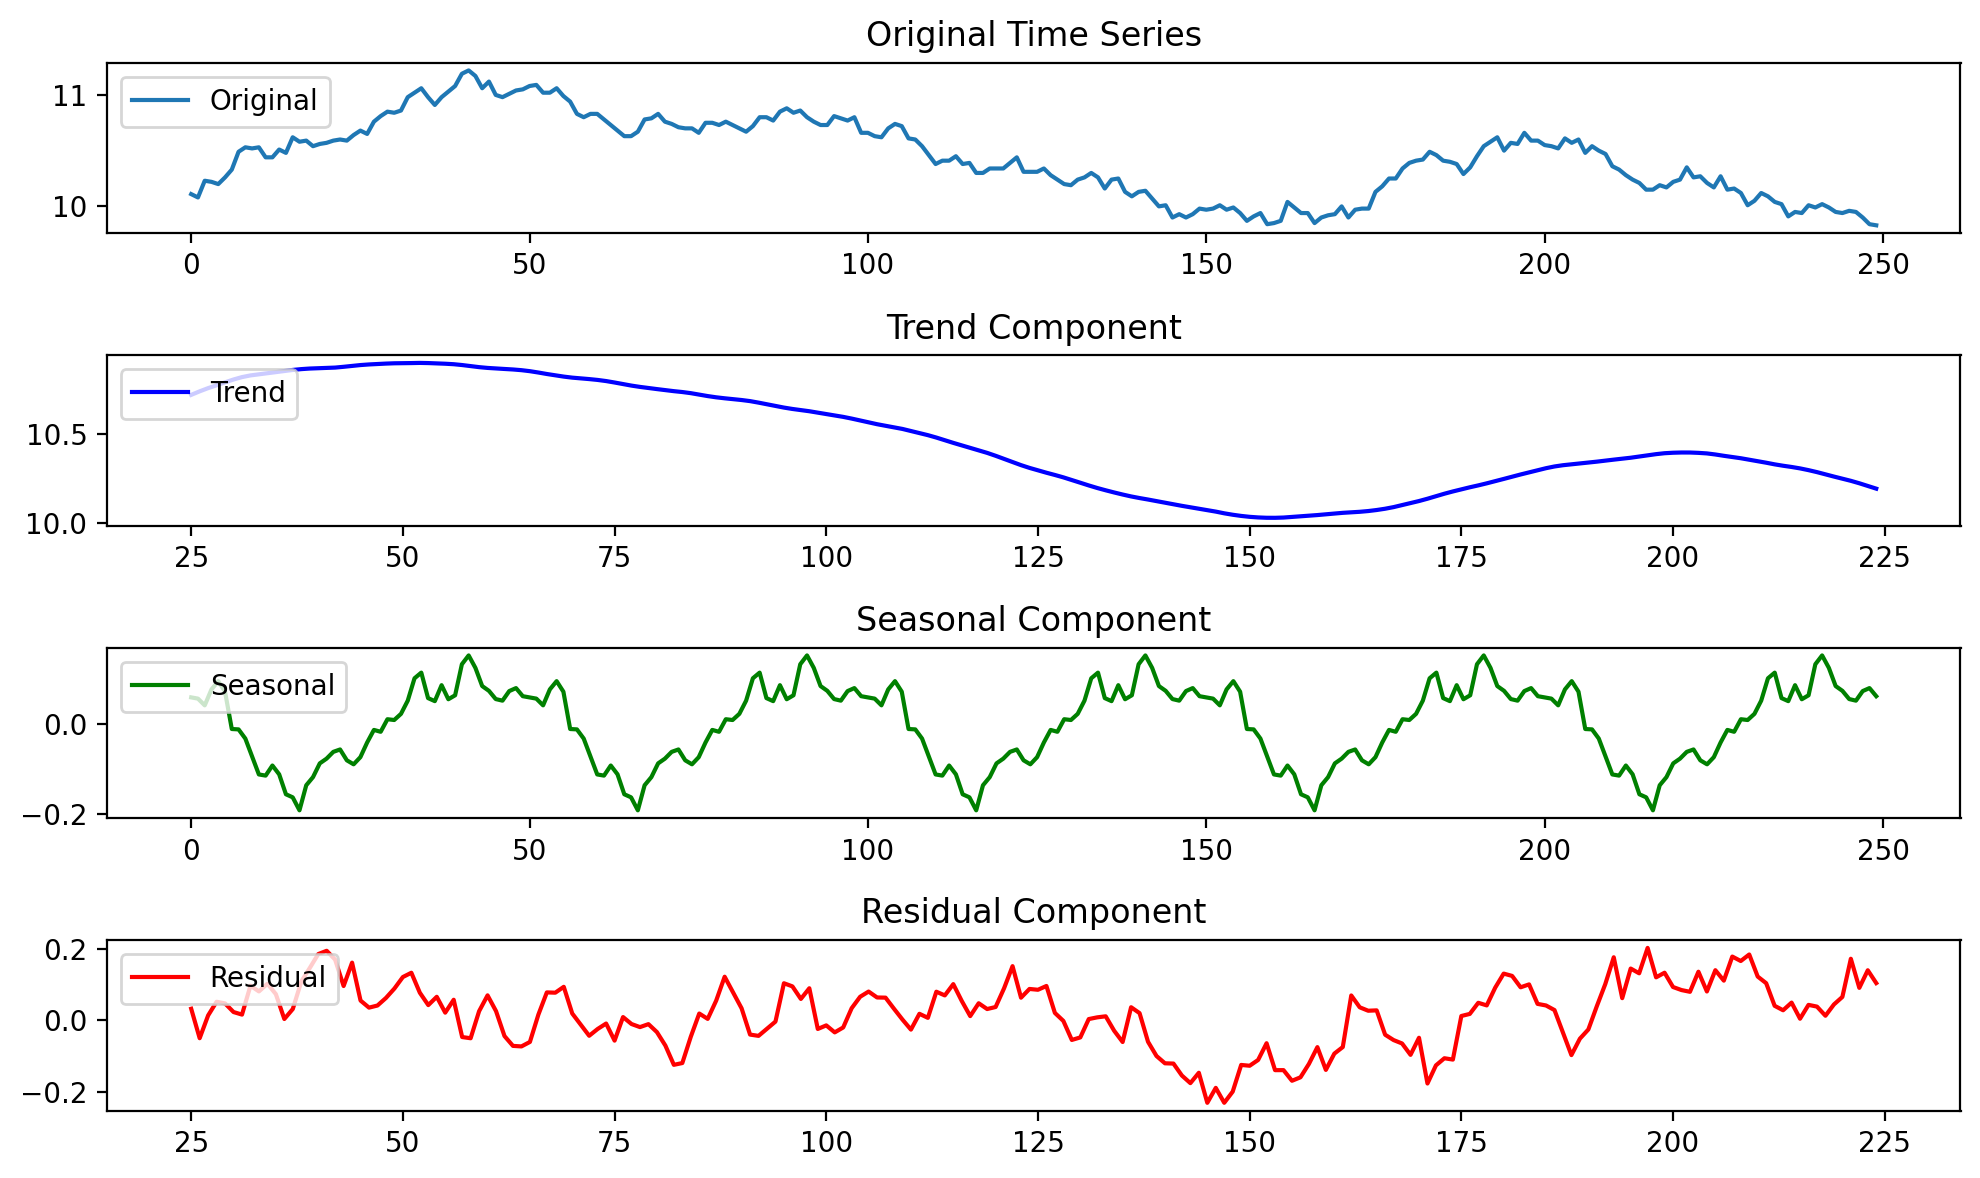

In [305]:
# Perform time series decomposition
result = seasonal_decompose(prcAll_np[1], model='additive', period=50)  # Set period if there is seasonality
# result = seasonal_decompose(prcAll_np[0], model='additive', period=7)  # Set period if there is seasonality

# Access the decomposed components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plot the original time series
plt.figure(figsize=(10, 6))
plt.subplot(4, 1, 1)
plt.plot(prcAll_np[1], label='Original')
plt.legend(loc='upper left')
plt.title('Original Time Series')

# Plot the trend component
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='upper left')
plt.title('Trend Component')

# Plot the seasonal component
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

# Plot the residual component
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual', color='red')
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()


We can see that the entire series was taken as the trend component and that there was no seasonality.
We can also see that the residual plot shows zero. This is a good example where the naive, or classical, decomposition was not able to separate the noise that we added from the linear trend.


In [306]:
y = pd.DataFrame({'price': prcAll_np[1]})
idx = pd.date_range("2023-01-01", periods=len(y))
idx = idx.to_period()
y.index = idx
print(y)

            price
2023-01-01  10.11
2023-01-02  10.08
2023-01-03  10.23
2023-01-04  10.22
2023-01-05  10.20
...           ...
2023-09-03   9.96
2023-09-04   9.95
2023-09-05   9.90
2023-09-06   9.84
2023-09-07   9.83

[250 rows x 1 columns]


            const  trend
2023-01-01    1.0    1.0
2023-01-02    1.0    2.0
2023-01-03    1.0    3.0
2023-01-04    1.0    4.0
2023-01-05    1.0    5.0
...           ...    ...
2023-09-03    1.0  246.0
2023-09-04    1.0  247.0
2023-09-05    1.0  248.0
2023-09-06    1.0  249.0
2023-09-07    1.0  250.0

[250 rows x 2 columns]


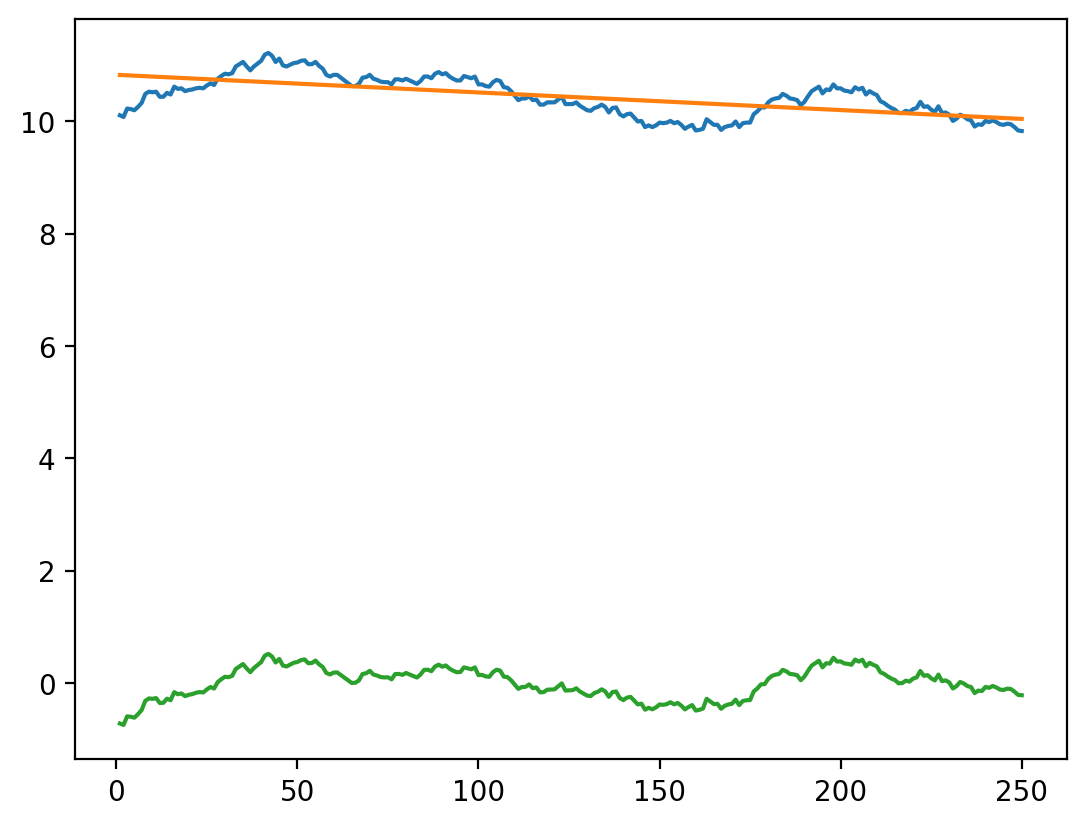

In [360]:

fourier = CalendarFourier(freq='D', order=6)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=False,
    drop=True,
    additional_terms=[fourier],
)
X = dp.in_sample()
print(X)
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_train = model.predict(X)
y_deseason = y - y_train
X_fore = dp.out_of_sample(steps=10)
y_fore = model.predict(X_fore)
ax = plt.plot(X.trend,y)
ax = plt.plot(X.trend, y_train)
ax = plt.plot(X.trend, y_deseason)

In [342]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta(365,"D") / pd.Timedelta(1,"D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

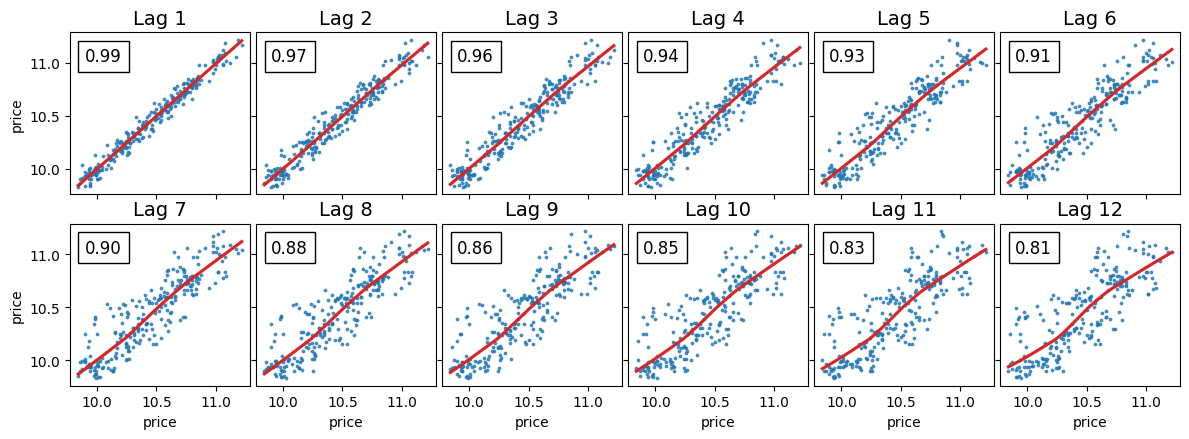

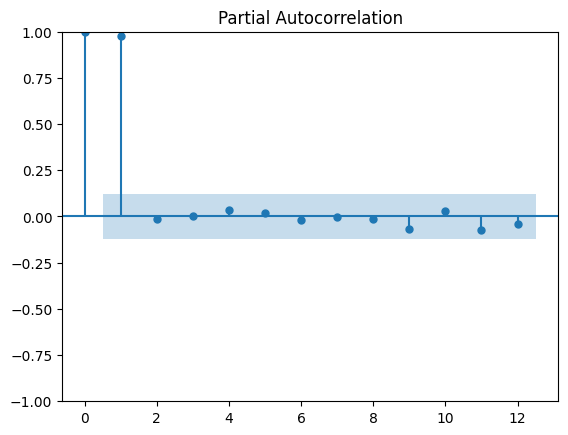

In [202]:
df = pd.DataFrame({
    'y': y.price,
    'y_lag_1': y.shift(1).price,
    'y_lag_2': y.shift(2).price,   
})
df.head()
_ = plot_lags(y.price, lags=12, nrows=2)
_ = plot_pacf(y.price, lags=12)

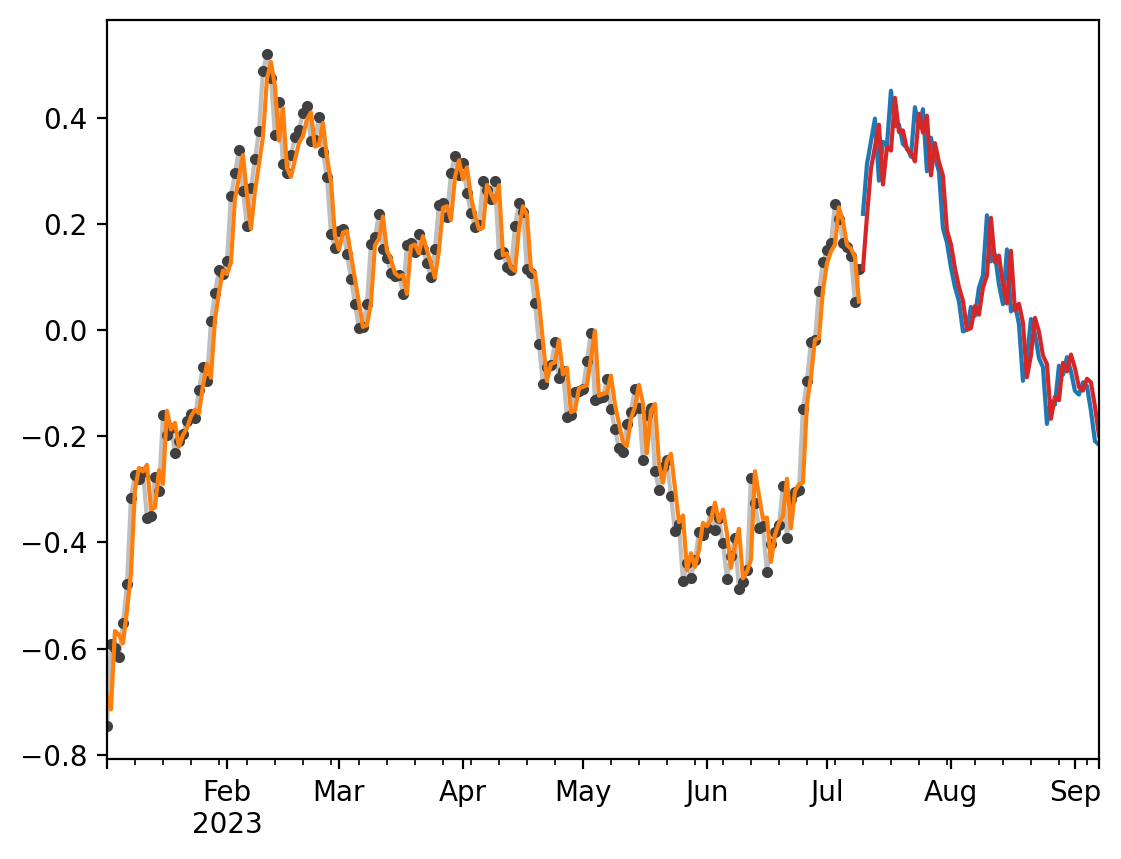

In [365]:
all_data_lag = make_lags(y_deseason.price, lags=1)
all_data_lag['y_deseason'] = y_deseason
all_data_lag = all_data_lag.dropna()
y_lag = all_data_lag.pop('y_deseason')
X_lag = all_data_lag
X_train, X_test, y_train, y_test = train_test_split(X_lag, y_lag, test_size=60, shuffle=False)
# # Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train).flatten(), index=y_train.index)
y_fore = pd.Series(model.predict(X_test).flatten(), index=y_test.index)

ax = y_train.plot(**plot_params)
ax = y_test.plot(ax=ax)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

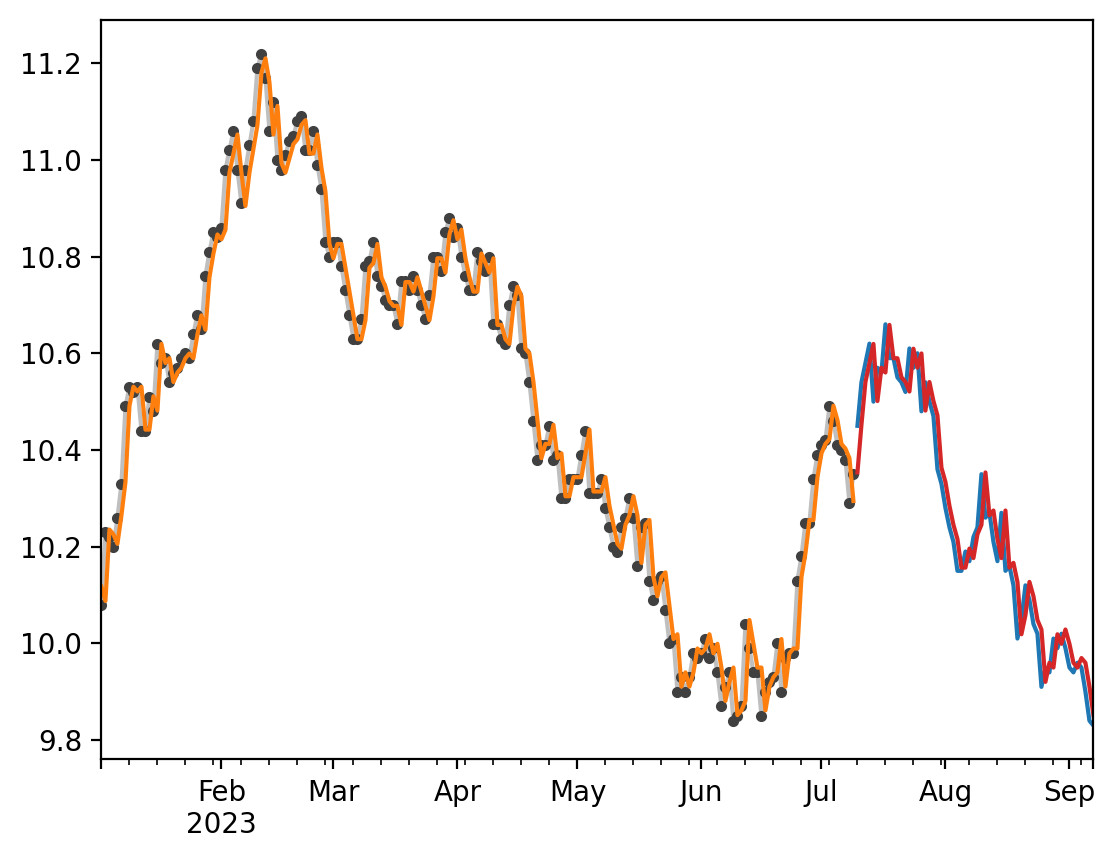

In [366]:
all_data_lag = make_lags(y.price, lags=1)
all_data_lag['y_deseason'] = y
all_data_lag = all_data_lag.dropna()
y_lag = all_data_lag.pop('y_deseason')
X_lag = all_data_lag
X_train, X_test, y_train, y_test = train_test_split(X_lag, y_lag, test_size=60, shuffle=False)
# # Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train).flatten(), index=y_train.index)
y_fore = pd.Series(model.predict(X_test).flatten(), index=y_test.index)

ax = y_train.plot(**plot_params)
ax = y_test.plot(ax=ax)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

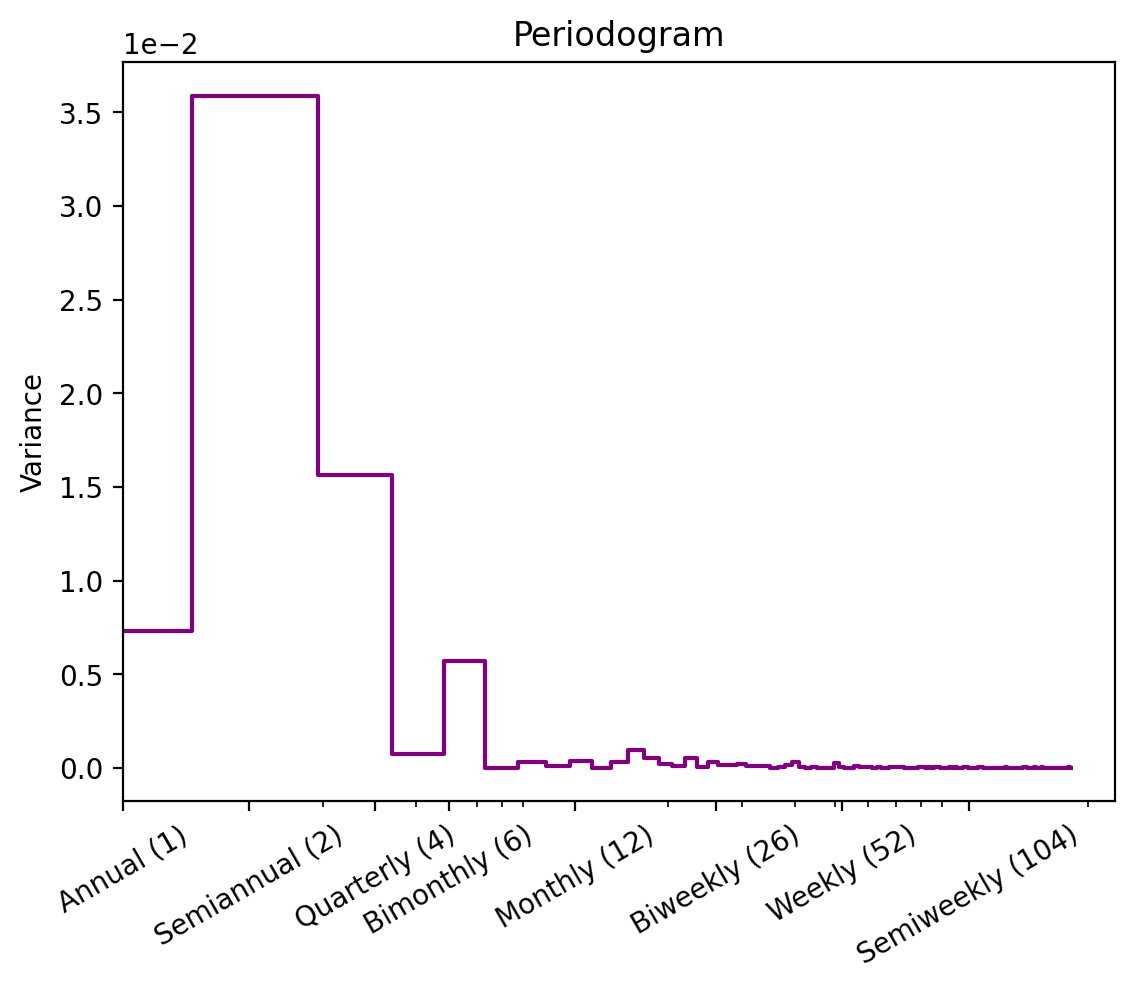

In [344]:
plot_periodogram(y.price);

# Stationarity Analysis
- A stationary time series has constant mean, variance, and autocorrelation structure over time.
- Check for stationarity by using statistical tests like Augmented Dickey-Fuller (ADF) test or visual inspection of rolling statistics.

# Time Series Modeling
- Choose an appropriate model based on the characteristics of your time series data. 
- Common models include ARIMA (AutoRegressive Integrated Moving Average), SARIMA (Seasonal ARIMA), Exponential Smoothing models, etc.
- Fit the selected model to your data, and adjust the model parameters to achieve a good fit

Note that advanced techniques like machine learning algorithms, deep learning models (e.g., LSTM, GRU), and time series-specific libraries (e.g., Prophet, statsmodels, or scikit-learn in Python) can help you with different aspects of time series analysis, depending on your data complexity and specific requirements.

# Model Evaluation and Selection:

Split the data into training and testing sets. Use the training data to fit the model and the testing data to evaluate its performance.
Evaluate the model using appropriate metrics such as mean absolute error (MAE), mean squared error (MSE), or root mean squared error (RMSE).
Compare different models to select the best-performing one.

# Forecasting
Once you have a satisfactory model, use it to forecast future values of the time series.
Consider uncertainty intervals or prediction intervals to account for the uncertainty in your forecasts.

# Interpretation and Communication
- Interpret the results of your analysis in the context of your problem or domain.
- Communicate your findings effectively, using visualizations and clear explanations.

# References
- https://machinelearningmastery.com/start-here/#timeseries 
    - https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/#:~:text=Time%20series%20decomposition%20involves%20thinking,time%20series%20analysis%20and%20forecasting.